# Trata as palavras-chave dos arquivos de audio

## Carrega a tabela que faz referencia aos arquivos de audio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

from scipy.io.wavfile import read as wavread
from scipy.io.wavfile import write as wavwrite

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

/home/usrp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df = pd.read_csv('Dataset_idx.csv')
df.head()

,Unnamed: 0,type,recOOV,file,idx_abre,Unnamed: 5
0,0,MISC,100,Estevan_3.wav,[4730 76320 131880 180000 212000],NaN
1,1,MISC,100,Marina_1.wav,[29450 106430 165400 214060 330190],NaN
2,2,MISC,100,Marina_4.wav,[12170 82450 138570 180800 218120 280850 347250],NaN
3,3,MISC,100,Marina_6.wav,[25130 57970 125860 199900 239820 277720 33808...,NaN
4,4,MISC,100,Natan_1.wav,[25670 107110 162700 208770 332250],NaN


## Formata as colunas de indexação em formatos de lista 

In [4]:
x = df['idx_abre']
iAbre = {}
for i in range(len(x)):
    p = x[i]
    p = p.replace('[','')
    p = p.replace(']','')
    
    p = p.split(' ')
#     print(p)
    if p[0] != '':
        iAbre[i] = list(map(int, p))
    else:
        iAbre[i] = list(map(int,[-1e9])) 

In [5]:
iAbre[0]

[4730, 76320, 131880, 180000, 212000]

## Definição das constantes

Com índices de cada arquivo de audio para cada palavra-chave, temos o centro de cada _frame_ que conterá as respectivas palavras-chave. 

Então, agora é preciso configurar todos os parâmetros para extração de _feature_ para a entrada. 
Isso ocorre pois estes parâmetros alterarão os tamanhos de _frames_ que serão agora coletados para cada _keyword_   

In [6]:
fs = 8000 # taxa de amostragem dos arquivos de audio

n_fft= 512   # tamanho da FFT para extração dos MFCCs
hop_length=0 # pulo entre cada frame
n_mels= 50   # numero de filtros MEL
n_mfcc= 15   # numero de coeficientes MFFC
ofs_mfcc=2   # offset dado para não utilizar os primeiros coeficientes MFCC      

fmin=100    # frequencia mínima do MFCC
fmax=4000   # frequencia máxima do MFCC

n_frames_MFCC = 10 # numero de frames MFCC que será usado para o reconhecimento.

frame_len = (n_frames_MFCC-1)*n_fft # tamanho do frame recortado para cada entrada
frame_lenD2 = int(frame_len/2) # tamanho do frame dividido por 2

In [7]:
frame_len, frame_lenD2

(4608, 2304)

## Extração das _Features_ que contém a palavra-chave

Agora que todas as constantes necessárias ja foram declaradas, é extraído de cada arquivo de áudio os _frames_ contendo a palavras-chave, conforme indexado por `iAbre[i]`.

Após extraído tais _frames_, é realizado o cálculo do MFCC para a extração das _features_ de cada _frame_.

In [8]:
frameMFCC = {}
kwFeat = {}
for i in range(len(df['file'])):
    wavstr = df['file'][i]  # extrai a string contendo o nome do arquivo de audio
    [_, data_file] = wavread(wavstr) # Lê todo o arquivo de audio

    data_file = data_file/32767 # normaliza as amostras do  áudio para o range [-1,1]
    N = data_file.shape[0]      # indica o tamanho do arquivo

#     # quando necessário é plotado o áudio do arquivo 
#     t = np.linspace(0, N/fs, N)
#     plt.plot(t, data_file)
    for j in range(len(iAbre[i])): # para cada audio, retira os frames kw e as features
        if iAbre[i][j] < 0:
            break
        
        frameSample = data_file[iAbre[i][j]-frame_lenD2:iAbre[i][j]+frame_lenD2]
        MFCCsample = librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                             n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)

        frameMFCC[j] = MFCCsample[ofs_mfcc:]
    
    kwFeat[i] = frameMFCC

number of keyword inputs: 106
number of keyword test inputs: 16


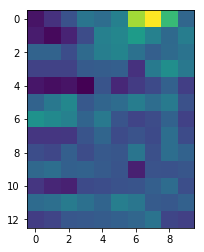

In [9]:
lenKW_1 = 0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') == -1:
        for j in range(len(iAbre[i])):
            if iAbre[i][j] < 0:
                break
            
            lenKW_1=lenKW_1+1

lenKW_1_test = 0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') != -1:
        for j in range(len(iAbre[i])):
            if iAbre[i][j] < 0:
                break
            
            lenKW_1_test=lenKW_1_test+1
            
print('number of keyword inputs:',lenKW_1)
print('number of keyword test inputs:',lenKW_1_test)
imgplot = plt.imshow(kwFeat[0][7])

In [10]:
list(map(int,['100']))

[100]

## Extração dos indices e das _Features_ _Out of Vocabulary_

Para treinar a rede, é necessário utilizar exemplos do que não é as palavras-chave, chamadas de _Out Of Vocabulary Word_ (OOV _words_).
Então, é indexado aleatoriamente trechos dos áudios contendo palavras OOV, para posteriormente a extração das _features_.

In [11]:
# OOV_lenght = 100 # gera OOV_length OutOfVoc frames por audio
OOV_lenght = list(map(int,df['recOOV'])) # gera OOV_length OutOfVoc frames por audio
iOOV = {}
# iOOVk = np.zeros(OOV_lenght)

for i in range(len(df['file'])):
    wavstr = df['file'][i]  # extrai a string contendo o nome do arquivo de audio
    [_, data_file] = wavread(wavstr) # Lê todo o arquivo de audio

    data_file = data_file/32767 # normaliza as amostras do  áudio para o range [-1,1]
    N = data_file.shape[0]      # indica o tamanho do arquivo
#     print(N)
    
    iOOVk = np.zeros(OOV_lenght[i])

    for k in range(OOV_lenght[i]):
        # tenta adquirir indices que indicam frames com Out Of Voc words
        # de forma aleatoria
        goodId = False
        while goodId == False:
            idx = np.random.randint(N-frame_len)+frame_lenD2 # gera numero aleatorio
            goodId = True
            for j in range(len(iAbre[i])): # analisa o indice criado com os indices das kw
                if abs(idx-iAbre[i][j]) < frame_len:
                    goodId = False
        
        iOOVk[k] = idx
            
    iOOV[i] = iOOVk.astype(int)

In [12]:
iOOV[1]

array([377878,  37907, 225683, 266144, 101531, 268794,  18636, 171478,
       250939,   7300, 430656, 309263, 139551, 138435,  95420,  71968,
       221922,  44497, 135134,  50867, 283265,  56453, 233088, 192572,
       196053, 354433, 308042,  23508, 268079, 209363, 346490, 309843,
        44354, 181016, 181742, 415339, 151058, 262394, 246575, 296328,
       349715, 338908,  83153, 301627, 270334, 400672, 357610, 246127,
       302811, 292559,  72205, 278913, 424262, 279775, 189093, 450156,
       180323, 383465, 188691, 139581, 340651, 400713, 138035, 403847,
       412358, 101643, 315824,  52243, 444335, 317020, 241313, 399080,
       399750, 139172, 119023, 190849, 263221, 412250,  83482, 431773,
        68995, 390136, 345452, 340633, 197571,  43423, 433565,   3599,
       262960, 128113, 180207, 245263, 316151, 267382,  69136, 371870,
       131517, 442064, 406742,  38157])

### Gera arquivo de audio contendo os trechos OOV para analise

In [13]:
i=2
wavstr = df['file'][i]  # extrai a string contendo o nome do arquivo de audio
[_, data_file] = wavread(wavstr) # Lê todo o arquivo de audio

data_file = data_file/32767 # normaliza as amostras do  áudio para o range [-1,1]
N = data_file.shape[0]      # indica o tamanho do arquivo

#     # quando necessário é plotado o áudio do arquivo 
#     t = np.linspace(0, N/fs, N)
#     plt.plot(t, data_file)

frameSample = np.zeros((frame_len,len(iOOV[i])))
for j in range(len(iOOV[i])): # para cada audio, retira os frames kw e as features
    frameSample[:,j] = data_file[iOOV[i][j]-frame_lenD2:iOOV[i][j]+frame_lenD2]

frameSample = frameSample.T.reshape(-1)
wavwrite('framesOOV.wav', fs, frameSample)

### Extração das Features OOV

In [14]:
frameMFCC = {}
oovFeat = {}
for i in range(len(df['file'])):
    wavstr = df['file'][i]  # extrai a string contendo o nome do arquivo de audio
    [_, data_file] = wavread(wavstr) # Lê todo o arquivo de audio

    data_file = data_file/32767 # normaliza as amostras do  áudio para o range [-1,1]
    N = data_file.shape[0]      # indica o tamanho do arquivo

#     # quando necessário é plotado o áudio do arquivo 
#     t = np.linspace(0, N/fs, N)
#     plt.plot(t, data_file)
    for j in range(len(iOOV[i])): # para cada audio, retira os frames kw e as features
        frameSample = data_file[iOOV[i][j]-frame_lenD2:iOOV[i][j]+frame_lenD2]
        
        MFCCsample = librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                             n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)
        
        frameMFCC[j] = MFCCsample[ofs_mfcc:]
    
    oovFeat[i] = frameMFCC

number of out-of-voc inputs: 2140
number of out-of-voc test inputs: 320


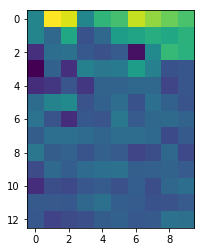

In [15]:
lenOOV = 0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') == -1:
        for j in range(len(iOOV[i])):
            lenOOV=lenOOV+1

lenOOVtest = 0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') != -1:
        for j in range(len(iOOV[i])):
            lenOOVtest=lenOOVtest+1
            
print('number of out-of-voc inputs:', lenOOV)
print('number of out-of-voc test inputs:', lenOOVtest)

imgplot = plt.imshow(oovFeat[0][99])

# Preparando o _Data Array_

Neste ponto é gerado _arrays_ para dados de treinamento e de teste.

Para isso, é atribuido _arrays_ de elementos OOV e elementos KW, concatenados, embaralhados, e separados em dados de treinamento e de teste.   

In [16]:
def splitData(x, y, p=0.2): # funcao para embaralhar e separar os dados em treinamento e teste
    shapeInX = x.shape
    shapeInY = y.shape
    datax = x.reshape(shapeInX[0],-1)
    
    data = np.concatenate((datax, y), axis=1)
    # random.randint(0, int(x.shape[0]*(1-p)))
    xScrambled = np.random.permutation(data)
    nLines = xScrambled.shape[0]

    data_train = xScrambled[0:int(round(nLines*(1-p))), :]
    data_test = xScrambled[int(round(nLines*(1-p))):, :]
#     print(nLines)
#     print(data_train.shape)
    
    shape_train = np.asarray(shapeInX)
    shape_train[0] = data_train.shape[0]
    x_train = data_train[:,:data_train.shape[1]-shapeInY[1]].reshape(tuple(shape_train))
    y_train = data_train[:,[data_train.shape[1]-shapeInY[1]]]
    
    
    shape_test = np.asarray(shapeInX)
    shape_test[0] = data_test.shape[0]
    x_test = data_test[:,:data_test.shape[1]-shapeInY[1]].reshape(tuple(shape_test))
    y_test = data_test[:,data_test.shape[1]-shapeInY[1]:]
    
    
    return (x_train, y_train), (x_test, y_test)

In [17]:
# gera os arrays OOV e KW, com suas respectivas labels
x_OOV = np.zeros((lenOOV, oovFeat[0][0].shape[0], oovFeat[0][0].shape[1],1))
x_KW_1 = np.zeros((lenKW_1, oovFeat[0][0].shape[0], oovFeat[0][0].shape[1],1))

x_OOV_test = np.zeros((lenOOVtest, oovFeat[0][0].shape[0], oovFeat[0][0].shape[1],1))
x_KW_1_test = np.zeros((lenKW_1_test, oovFeat[0][0].shape[0], oovFeat[0][0].shape[1],1))

# y_OOV = np.concatenate((np.ones((lenOOV, 1)), np.zeros((lenOOV,  1))), axis=1)
# y_KW_1 = np.concatenate((np.zeros((lenKW_1,  1)), np.ones((lenKW_1, 1))), axis=1)
y_OOV = np.zeros((lenOOV,  1))
y_KW_1 = np.ones((lenKW_1, 1))

y_OOV_test = np.zeros((lenOOVtest,  1))
y_KW_1_test = np.ones((lenKW_1_test, 1))

k=0
m=0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') == -1:
        for j in range(len(iOOV[i])): 
            x_OOV[k,:,:,0] = oovFeat[i][j]
            k=k+1
    else:
        for j in range(len(iOOV[i])): 
            x_OOV_test[m,:,:,0] = oovFeat[i][j]
            m=m+1
        

k=0
m=0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') == -1:
        for j in range(len(iAbre[i])):
            if iAbre[i][j] < 0:
                break
            x_KW_1[k,:,:,0] = kwFeat[i][j]
            k=k+1
    else:
        for j in range(len(iAbre[i])): 
            if iAbre[i][j] < 0:
                break
                
            x_KW_1_test[m,:,:,0] = kwFeat[i][j]
            m=m+1

print('Keyword Abre Array Shape:', x_KW_1.shape)
print('Out Of Voc Array Shape:', x_OOV.shape)
        
x = np.concatenate((x_OOV, x_KW_1), axis=0)
y = np.concatenate((y_OOV, y_KW_1), axis=0)

print('\nConcatenate Array Shape:', x.shape)

# print(x.shape)
# print(x_OOV.shape)
# print(x_KW_1.shape)
# print(y.shape)
# print(y_OOV.shape)
# print(y_KW_1.shape)

(x_train, y_train), (x_test, y_test) = splitData(x, y, p=0.1)
print('\nTrain data shape:', x_train.shape)
print('Test data shape:', x_test.shape)

# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

print('\ncounting of Truth keywords in Test Data:', list(y_test[:]).count(1))
print('counting of OOV words in Test Data:', list(y_test[:]).count(0))

Keyword Abre Array Shape: (106, 13, 10, 1)
Out Of Voc Array Shape: (2140, 13, 10, 1)

Concatenate Array Shape: (2246, 13, 10, 1)

Train data shape: (2021, 13, 10, 1)
Test data shape: (225, 13, 10, 1)

counting of Truth keywords in Test Data: 9
counting of OOV words in Test Data: 216


In [19]:
prepros_feat = [fs,# = 16000 # taxa de amostragem dos arquivos de audio
                n_fft,#= 512   # tamanho da FFT para extração dos MFCCs
                hop_length,#=0 # pulo entre cada frame
                n_mels,#= 50   # numero de filtros MEL
                n_mfcc,#= 16   # numero de coeficientes MFCC
                ofs_mfcc,#=2   # offset dado para não utilizar os primeiros coeficientes MFCC      
                fmin,#=100    # frequencia mínima do MFCC
                fmax,#=4000   # frequencia máxima do MFCC
                n_frames_MFCC,# = 10 # numero de frames MFCC que será usado para o reconhecimento.]
                frame_len, #= (n_frames_MFCC-1)*n_fft # tamanho do frame recortado para cada entrada
                frame_lenD2 #= int(frame_len/2) # tamanho do frame dividido por 2
                ]

Rede = {}
Rede['preFeat'] = prepros_feat
Rede['x_train'] = x_train
Rede['y_train'] = y_train
Rede['x_test'] = x_test
Rede['y_test'] = y_test

# Rede['Model'] = model
# Rede['History'] = history
# Rede = [prepros_feat, [x_train, y_train, x_test, y_test]]

# pickle.dump( Rede, open( 'RedeTeste1.pickle', 'wb' ) )
np.save("DataSet1.npy", Rede)


In [20]:
Rede = np.load("DataSet1.npy").item()

# prepros_feat 	= Rede['preFeat']  
# x_train 		= Rede['x_train']
# y_train			= Rede['y_train'] 
# x_test 			= Rede['x_test'] 
# y_test 			= Rede['y_test']
prepros_feat 	= Rede['preFeat']  
x_train 		= Rede['x_train']
y_train			= Rede['y_train'] 
x_test 			= Rede['x_test'] 
y_test 			= Rede['y_test']

fs = prepros_feat[0] # = 16000 # taxa de amostragem dos arquivos de audio
n_fft = prepros_feat[1] #= 512   # tamanho da FFT para extração dos MFCCs
hop_length = prepros_feat[2] #=0 # pulo entre cada frame
n_mels = prepros_feat[3] #= 50   # numero de filtros MEL
n_mfcc = prepros_feat[4] #= 16   # numero de coeficientes MFCC
ofs_mfcc = prepros_feat[5] #=2   # offset dado para não utilizar os primeiros coeficientes MFCC      
fmin = prepros_feat[6] #=100    # frequencia mínima do MFCC
fmax = prepros_feat[7] #=4000   # frequencia máxima do MFCC
n_frames_MFCC = prepros_feat[8] # = 10 # numero de frames MFCC que será usado para o reconhecimento.]
frame_len = prepros_feat[9]
frame_lenD2 = prepros_feat[10]


# Test with Convolutional Layers

In [21]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten

input_shape = x_train.shape[1:]
num_classes = 2

# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

print(input_shape)
model = Sequential()
model.add(Conv2D(3, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(4, (2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=40,
          batch_size=128)

score = model.evaluate(x_test, y_test, batch_size=128)
print(score[1])

(13, 10, 1)
Epoch 1/40
2021/2021 [==============================] - 0s 236us/step - loss: 5.2503 - acc: 0.3909
Epoch 2/40
2021/2021 [==============================] - 0s 77us/step - loss: 1.2021 - acc: 0.7709
Epoch 3/40
2021/2021 [==============================] - 0s 74us/step - loss: 0.5497 - acc: 0.8956
Epoch 4/40
2021/2021 [==============================] - 0s 84us/step - loss: 0.4510 - acc: 0.9080
Epoch 5/40
2021/2021 [==============================] - 0s 74us/step - loss: 0.3493 - acc: 0.9070
Epoch 6/40
2021/2021 [==============================] - 0s 74us/step - loss: 0.2642 - acc: 0.9278
Epoch 7/40
2021/2021 [==============================] - 0s 78us/step - loss: 0.2140 - acc: 0.9451
Epoch 8/40
2021/2021 [==============================] - 0s 70us/step - loss: 0.1822 - acc: 0.9515
Epoch 9/40
2021/2021 [==============================] - 0s 70us/step - loss: 0.1604 - acc: 0.9634
Epoch 10/40
2021/2021 [==============================] - 0s 67us/step - loss: 0.1446 - acc: 0.9688
Epoch 

In [41]:
score

[0.016585472971200943, 1.0]

In [36]:
frameMFCC.shape

(15, 10)

In [22]:
idxFile = 0
idxSmp  = 3

k=0
for i in range(len(df['file'])):
    for j in range(len(iAbre[i])):
#         plt.imshow(kwFeat[i][j])
#         plt.show()
        k=k+1

print(k)

74


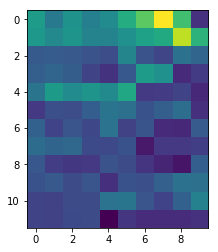

In [25]:
wavwrite('frame.wav', fs, frame1)

In [ ]:
np.load()